## Extraction Features d'Images via réseaux de neurones convolutifs CNN et Transfer Learning
Suite aux résultats décevants de l'utilisation de SIFT et kMeans pour segmenter nos photos, nous allons tester une méthode d'extraction de features à l'aide d'un réseau de neurone CNN spécialement conçus pour traiter des images en entrée. Leur architecture est alors plus spécifique : elle est composée de deux blocs principaux:

 - Le premier bloc fonctionne comme un extracteur de features. (Convolution)
 - Le second bloc transforme les valeurs du vecteur en entrée (avec plusieurs combinaisons linéaires et fonctions d'activation) pour renvoyer un nouveau vecteur en sortie

4 Couches pour ce réseau de Neurones:
1. Convolution
2. Pooling
3. ReLU
4. Fully-connected

Généralement, le processus se termine par l'utilisation 
 - d'une regression logistique, pour une classification binaire
 - d'une regression softmax, pour une classification multiple

[Source](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/?utm_medium=email&utm_content=nov-18-has-completed-mentoring-session-student&bsft_clkid=69552619-a88e-42e1-8ba9-0dce105e3cd6&bsft_uid=51587838-182a-40d2-b9d7-78728e017104&bsft_mid=8c6b0705-d295-495d-9e61-f27b77e9e293&bsft_eid=7244055d-47f0-a6f2-c394-7a20ebb3a726&bsft_txnid=39b33dc8-964d-4eea-8540-ab265ba185ce&bsft_mime_type=html&bsft_ek=2021-10-19T18%3A44%3A41Z&bsft_aaid=a265d396-7432-4eb2-9c9a-ba5eea75629e&bsft_tv=10)

[Cours OC Réseau de Neurones](https://openclassrooms.com/fr/courses/4470406-utilisez-des-modeles-supervises-non-lineaires/4730716-entrainez-un-reseau-de-neurones-simple#/id/r-4730736)

[Cours OC Images](https://openclassrooms.com/fr/courses/4470531-classez-et-segmentez-des-donnees-visuelles/5082166-quest-ce-quun-reseau-de-neurones-convolutif-ou-cnn#/id/r-5117486)

Le Transfer Learning (Apprentissage par transfert) permet de faire du Deep Learning, c'est à dire qu'il utilise les connaissances acquises par un réseau de neurones lors de la résolution d'un problème afin d'en résoudre un autre plus ou moins similaire. On réalise ainsi un transfert de connaissances.

Le Transfer Learning est une technique très utilisée en pratique et simple à mettre en œuvre. Elle nécessite d'avoir un réseau de neurones déjà entraîné, de préférence sur un problème proche de celui qu'on veut résoudre. 

Nous utiliserons la bibliothèque de Deep Learning **Keras** dans le chapitre suivant.

### Extraction de feature avec un CNN pré-entrainé


In [52]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.image import imread
from numpy import expand_dims

#import plotly.express as px

import seaborn as sns
sns.set_theme()

# File system manangement
import os

from keras import Model, preprocessing, regularizers
from keras.applications import VGG16, EfficientNetB0
from keras.applications.vgg16 import preprocess_input, decode_predictions
#from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense, Flatten, Activation, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras_preprocessing.image import ImageDataGenerator
from keras.preprocessing import image as p_img
from keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn import cluster, metrics, preprocessing, manifold, decomposition
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.metrics.cluster import adjusted_rand_score


import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from joblib import dump, load


In [53]:
#from keras.models import Sequential
#from keras.layers import Conv2D, MaxPooling2D
#from keras.layers import Flatten, Dense
#import tensorflow as tf

### Fonctions

In [54]:
#Function to plot PIE Chart of n tops values in dataframe
def plot_ntops_pie(data: pd.DataFrame, colunm_name, ntops: int, plot_others: bool, plot_na: bool):
    podium_tops = pd.DataFrame(data[colunm_name].value_counts(dropna=True, sort=True).head(ntops))
    if (plot_others == True):
        remainings_counts = sum(data[colunm_name].value_counts(dropna=True)[ntops:])
        remainings_below = pd.DataFrame({colunm_name : [remainings_counts]}, index=['others'])
        podium_tops = pd.concat([podium_tops, remainings_below], ignore_index = None, axis = 0)
    if (plot_na == True):
        na_counts = data[colunm_name].isna().sum()
        remainings_na = pd.DataFrame({colunm_name : [na_counts]}, index=['NAN'])
        podium_tops = pd.concat([podium_tops, remainings_na], ignore_index = None, axis = 0)
    
    #Définir la taille du graphique
    plt.figure(figsize=(8,8))
    #Définir lae type du graphique, ici PIE CHart avec en Labels l'index du nom des libelle
    #l'autopct sert ici à afficher le % calculé avec 1 décimal derriere la virgule
    plt.pie(podium_tops[colunm_name], labels=podium_tops.index, autopct='%1.1f%%')
    #Afficher la légende en dessous du graphique au centre
    plt.legend(loc='upper left', bbox_to_anchor=(0.1, -0.01), fancybox=True, shadow=None, ncol=2)
    plt.title(f"{ntops} most presents values identified in column {colunm_name} .\nTOTAL unique = {len(data[colunm_name].unique())}")
    #Afficher le graphique
    plt.show()
    return(podium_tops)

In [55]:
def create_lists(data: pd.DataFrame):
    list_inside=[data['image_full_name'][i] for i in range(len(data)) if data["label"][i]=="inside"]
    list_outside=[data['image_full_name'][i] for i in range(len(data)) if data["label"][i]=="outside"]
    list_drink=[data['image_full_name'][i]for i in range(len(data)) if data["label"][i]=="drink"]
    list_food=[data['image_full_name'][i] for i in range(len(data)) if data["label"][i]=="food"]
    list_menu=[data['image_full_name'][i] for i in range(len(data)) if data["label"][i]=="menu"]
    return (list_inside, list_outside, list_drink, list_food, list_menu)

images = []
def list_fct(data: pd.DataFrame, name) :
    #list_image_name = [photos_full_name[i] for i in range(len(images_df)) if images_df["label"][i]==name]
    list_image_name = [data['image_full_name'][i] for i in range(len(data)) if data["label"][i]==name]
    return (list_image_name)

### Import du Dataset
Nous chargeons le dataframe que nous avions préparé dans le notebook précedent

In [56]:
global_dir = 'C:/Users/blanc/OpenClassrooms/IA_Project6_Openclassrooms_IAstart-up/'
dataset_global_dir = (global_dir + 'dataset')
path_photos = (dataset_global_dir+"/photos")
photo_example = (path_photos+"/twpKQbvG1fIyl8PT1V-_9g.jpg")

In [57]:
# Load data
images_df = pd.read_csv(dataset_global_dir+'/images_df.csv')
#Remove unconsistent data (where jpg are minimum size of 1ko)
#images_df = images_df.loc[(images_df['size'] > images_df['size'].min()),:]
print('data shape: ', images_df.shape)
print('data info: ', images_df.info())

data shape:  (200098, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200098 entries, 0 to 200097
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   photo_id         200098 non-null  object
 1   business_id      200098 non-null  object
 2   caption          96733 non-null   object
 3   label            200098 non-null  object
 4   image_full_name  200098 non-null  object
 5   image_name       200098 non-null  object
 6   image_ext        200098 non-null  object
 7   size             200098 non-null  int64 
 8   path             200098 non-null  object
 9   label_encoded    200098 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 15.3+ MB
data info:  None


In [58]:
n_sample = 1000 ## n_sample = len(photos_name)
#weighted_images_df = images_df.groupby("label").sample(n=n_sample, random_state=0).reset_index(drop = True)

weighted_images_df = images_df.loc[(images_df['size'] > images_df['size'].min()),:].groupby("label").sample(n=n_sample, random_state=0).reset_index(drop = True)
print('data shape: ', weighted_images_df.shape)
print('data info: ', weighted_images_df.info())

data shape:  (5000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   photo_id         5000 non-null   object
 1   business_id      5000 non-null   object
 2   caption          2347 non-null   object
 3   label            5000 non-null   object
 4   image_full_name  5000 non-null   object
 5   image_name       5000 non-null   object
 6   image_ext        5000 non-null   object
 7   size             5000 non-null   int64 
 8   path             5000 non-null   object
 9   label_encoded    5000 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 390.8+ KB
data info:  None


In [59]:
list_inside, list_outside, list_drink, list_food, list_menu = create_lists(images_df)

In [60]:
list_labels = images_df['label'].unique()
list_labels

array(['inside', 'outside', 'drink', 'food', 'menu'], dtype=object)

## Utilisation du VGG1-16 pré-entrainé (fourni par Keras)

### Test du modèle pré-entrainé sur une photo

Charger un modèle sur Keras permet de charger automatiquement les poids pré-entraînés sur lesquels le modèle sera indexé, c’est ce qu’on appelle du Transfert Learning.

Dans Keras Application, VGG16 a été entraînés sur plus d’un million d’images provenant de la base de données ImageNet.
Ce réseau de neurones peut classer les images en 1000 classes d’objets, tels que des voitures, des souris, des crayons et de nombreux animaux.

La taille de l’image d’entrée par défaut de VGG-16 est de 224×224. On redimensionne donc notre image.

Nous allons étudier les résultats fournis par ce réseau de neurones, en utilisant le modèle pré-entrainé.

[VGG16 Tuto](https://www.inside-machinelearning.com/vgg16-tutoriel-simple-et-detaille/)


In [61]:
# load model VGG
#model = VGG16(include_top=False)
model = VGG16() # Création du modèle VGG-16 implementé par Keras

In [62]:
img = load_img(photo_example, target_size=(224, 224))  # Charger l'image
img = img_to_array(img)  # Convertir en tableau numpy, pour le rendre compatible avec le réseau de neurones
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon) - La dimension par défaut de VGG16 (None,224,224,3). On ajoute donc une autre dimension a notre matrice.
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

In [63]:
y = model.predict(img)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

1/1 [==============================] - 0s 200ms/step


In [64]:
# Afficher les 5 classes les plus probables
print('Top 5 :', decode_predictions(y, top=5)[0])

Top 5 : [('n07873807', 'pizza', 0.96986806), ('n07697537', 'hotdog', 0.0071540596), ('n07579787', 'plate', 0.0031327477), ('n03871628', 'packet', 0.0030137831), ('n07880968', 'burrito', 0.002725584)]


In [65]:
# Afficher les 3 classes les plus probables
labels = decode_predictions(y)
print('%s (%.2f%%)' % (labels[0][0][1], labels[0][0][2]*100))
print('%s (%.2f%%)' % (labels[0][1][1], labels[0][1][2]*100))
print('%s (%.2f%%)' % (labels[0][2][1], labels[0][2][2]*100))

pizza (96.99%)
hotdog (0.72%)
plate (0.31%)


In [66]:
photo_example = (path_photos+'/99T9nLsdcOT_vXUj7dvWDw.jpg') #Il s'agit d'un restaurant, vu de l'exterieur, par la terrasse

# example of using a pre-trained model as a classifier

# load an image from file
image = load_img(photo_example, target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# load the model
model = VGG16()
# predict the probability across all output classes
y = model.predict(image)
# convert the probabilities to class labels
#label = decode_predictions(y)
# retrieve the most likely result, e.g. highest probability
#label = label[0][0]
# print the classification
#print('%s (%.2f%%)' % (label[1], label[2]*100))

# Afficher les 3 classes les plus probables
labels = decode_predictions(y)
print('%s (%.2f%%)' % (labels[0][0][1], labels[0][0][2]*100))
print('%s (%.2f%%)' % (labels[0][1][1], labels[0][1][2]*100))
print('%s (%.2f%%)' % (labels[0][2][1], labels[0][2][2]*100))

1/1 [==============================] - 0s 188ms/step
mobile_home (25.62%)
sliding_door (18.21%)
gas_pump (10.99%)


### Test du modèle pré-entrainé sur l'ensemble du jeu de donnée

In [67]:
# identification des classes d'images a partir de modèle CNN pré-entrainé
Image_classes = []
Images_class_name = []
Images_class_confidence_level = []

weighted_images_df['Class_Name_VGG'] = np.nan
weighted_images_df['Class_Confidence_Level'] = np.nan

range_study = n_sample #len(photos_name)

path = (path_photos+'/')

for name in list_labels : #We run on n_sample picture, of each of the 5 label sequentially.
    # print("-------")
    for image_num in range(range_study):
        #if image_num%100 == 0 : print(image_num)
        
        filename = list_fct(weighted_images_df, name)[image_num]
        filename_path = path + filename
        #preprocess Image: Open, Grayscale, (Resize), (Equalize), Blur in option
        #image = preprocess(filename_path, colors, resize, equalize, blur, ksize) #preprocess(filename, blur, ksize)
        
        #Classification CNN pré-entrainé
        # load an image from file
        img = load_img(filename_path, target_size=(224, 224))  # Charger l'image
        
        # convert the image pixels to a numpy array
        img = img_to_array(img)  # Convertir en tableau numpy
        
        # reshape data for the model
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
        
        # prepare the image for the VGG model
        img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16
        
        # predict the probability across all output classes
        y = model.predict(img) # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)
        
        # convert the probabilities to class labels
        label = decode_predictions(y)

        # retrieve the most likely result, e.g. highest probability
        label = label[0][0]
        
        # print the classification
        #print(f'image {filename} label determined is : **{label[1]}** with confidence level = **{round(label[2]*100,2)} %**')
        
        Image_classes.append(y)
        Images_class_name.append(label[1])
        Images_class_confidence_level.append(label[2]*100)
        
        
        weighted_images_df.loc[(weighted_images_df['image_full_name'] == filename), 'Class_Name_VGG'] = label[1]
        weighted_images_df.loc[(weighted_images_df['image_full_name'] == filename), 'Class_Confidence_Level'] = (label[2]*100)
        
Image_classes_by_img = np.asarray(Image_classes)
Image_classes_all    = np.concatenate(Image_classes_by_img, axis=0)
Images_class_name_by_img = np.asarray(Images_class_name)
Images_class_confidence_level = np.asarray(Images_class_confidence_level)


print()
print(f"Les classes prédites (parmi les {n_sample} classes pré-entrainées d'ImageNet) soint disponible dans **Image_classes_by_img**: {Image_classes_by_img.shape}")


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 184ms/step


1/1 [==============================] - 0s 203ms/step


1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 152ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 129ms/step


1/1 [==============================] - 0s 133ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 127ms/step


1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 127ms/step


1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 136ms/step

Les classes prédites (parmi les 1000 classes pré-entrainées d'ImageNet) soint disponible dans **Image_classes_by_img**: (5000, 1, 1000)


In [68]:
weighted_images_df.sort_values(by=['Class_Confidence_Level'], ascending=False).head(3)

photo_id             business_id  \
3893  Dn33EEAuNXua2SzvnnPtng  oEwmCZknUHgHfEBdKA2SZA   
3112  IQmlyupt4KOvFtdq1hYw0g  V6bbrITJZLj5mCLQGb4jqg   
1531  DewIVc_6PRxOCSuP_zNoow  RCbsQfcnMbyRkmgE7JHjXQ   

                                  caption label             image_full_name  \
3893  Vietnamese, Pho, Rice & Egg noodles  menu  Dn33EEAuNXua2SzvnnPtng.jpg   
3112                                 Menu  menu  IQmlyupt4KOvFtdq1hYw0g.jpg   
1531     Dark chocolate covered pretzels.  food  DewIVc_6PRxOCSuP_zNoow.jpg   

                  image_name image_ext   size  \
3893  Dn33EEAuNXua2SzvnnPtng      .jpg  36839   
3112  IQmlyupt4KOvFtdq1hYw0g      .jpg  52850   
1531  DewIVc_6PRxOCSuP_zNoow      .jpg  26897   

                                                   path  label_encoded  \
3893  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              3   
3112  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              3   
1531  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              1   

     Class_Name_VGG  Class_Confidence_Level  
3893           menu               99.999964  
3112           menu               99.999964  
1531        pretzel               99.999857

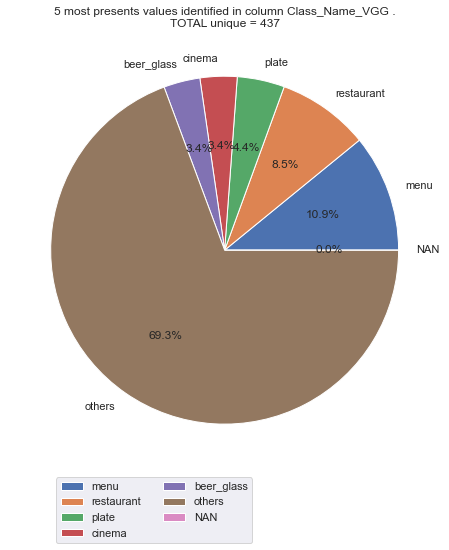

Class_Name_VGG
menu                   545
restaurant             427
plate                  220
cinema                 172
beer_glass             169
others                3467
NAN                      0

In [69]:
plot_ntops_pie(weighted_images_df, 'Class_Name_VGG', 5, True, True)

In [70]:
list_labels = weighted_images_df['label'].unique()
list_labels

array(['drink', 'food', 'inside', 'menu', 'outside'], dtype=object)

In [71]:
#weighted_images_df = weighted_images_df.sort_values(by=['Class_Confidence_Level'], ascending=False).head(3)
#weighted_images_df

drink


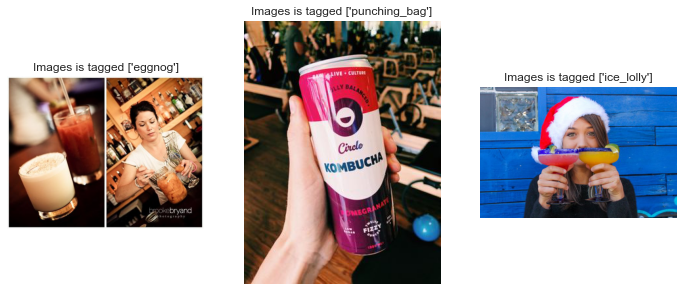

food


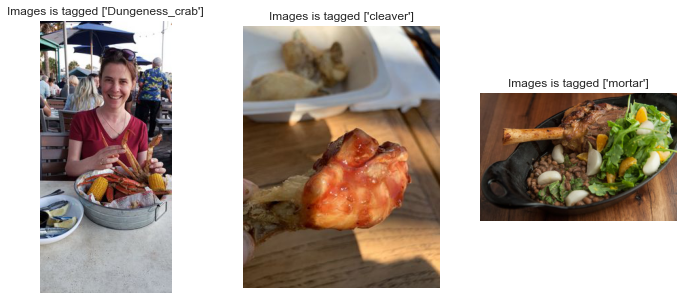

inside


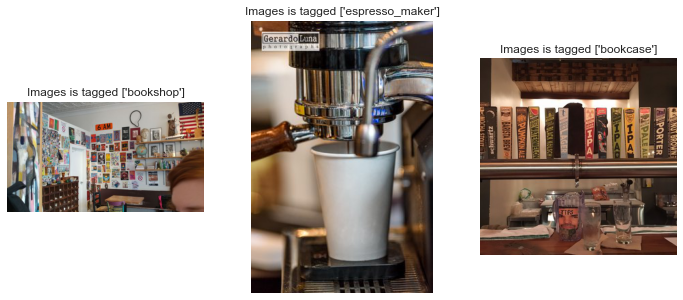

menu


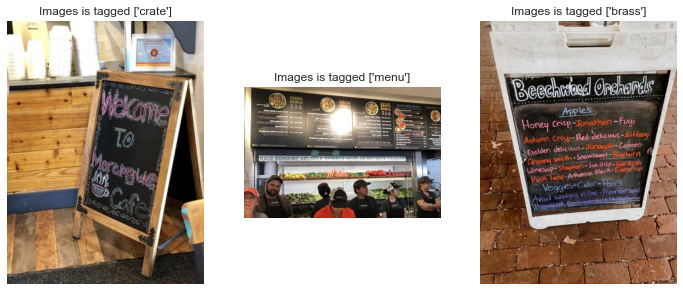

outside


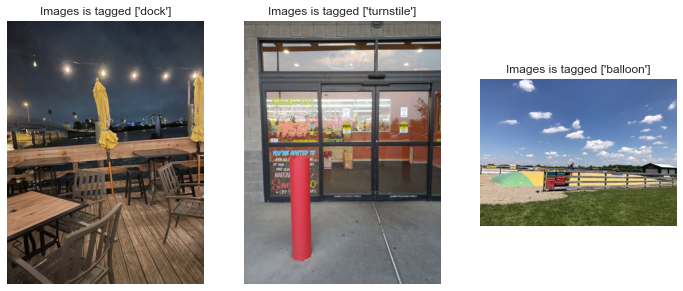

In [72]:
path = (path_photos+'/')

for name in list_labels :
    print(name)
    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(hspace=0.5)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        #filename = path + list_fct(weighted_images_df, name)[i+10]
        filename = list_fct(weighted_images_df, name)[i+10]
        filename_path = path + filename
        image = imread(filename_path)
        image_tag = weighted_images_df.loc[(weighted_images_df['image_full_name'] == filename), 'Class_Name_VGG']
        plt.title(f'Images is tagged {image_tag.values}')
        plt.axis('off')
        plt.grid(None)
        plt.imshow(image)
        #print(f'Images is tagged by VGG model as {image_tag.values}')
    plt.show()

Dans la section précédente, nous avons utilisé le réseau VGG-16 fourni par Keras pour résoudre le problème de classification que celui sur lequel il a été pré-entraîné (classification à 1000 classes avec ImageNet).

Dans la section ci-dessous, nous devons mettre en oeuvre le Transfer Learning : fine-tuning total, extraction des features, et fine-tuning partiel. 
Il faut remplacer les dernières couches fully-connected qui permettent de classifier l'image dans une des 1000 classes ImageNet) par un classifieur plus adapté à notre problème: Les 5 classes correspondantes à:
    
    inside
    outside
    drink
    food
    menu

## Extraction de features à partir du modèle entrainé

Quelques source à regarder ci-dessous:

 - [ResNet50 (keras)](https://www.kaggle.com/code/trolukovich/food-5k-feature-extraction-with-resnet50-keras/notebook)
 - [VGG16 Tuto](https://www.kaggle.com/code/shahules/getting-started-with-cnn-and-vgg16#Extracting-features-using-VGG16)
 - [VGG6 Example](https://www.kaggle.com/code/loaiabdalslam/brain-tumor-mri-classification-vgg16?scriptVersionId=19039704&cellId=43)

In [73]:
input_shape = (224,224,3)
# load the model
#model = VGG16() - include_top means that we load model without last fully connected layers
model = VGG16(weights="imagenet",include_top=False,pooling="avg")
model

img.shape in numpy array is : (224, 224, 3)
img.shape after reshape is : (1, 224, 224, 3)
1/1 [==============================] - 0s 164ms/step
features shape is = (512,)


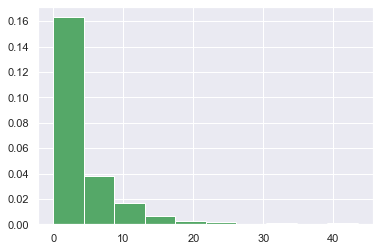

In [74]:
photo_example = (path_photos+'/YQAHb6W8LuInYrniosDhCw.jpg') #Il s'agit d'un restaurant, vu de l'exterieur, par la terrasse

# load an image from file
img = load_img(photo_example, target_size=(224, 224))  # Charger l'image
        
# convert the image pixels to a numpy array
img = img_to_array(img)  # Convertir en tableau numpy
print(f"img.shape in numpy array is : {img.shape}")

# expand dimensions so that it represents a single 'sample'
#img = expand_dims(img, axis=0)
#print(f"img.shape after expand_dims is : {img.shape}")
        
# reshape data for the model
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
print(f"img.shape after reshape is : {img.shape}")

# prepare the image for the VGG model
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

# Extracting our features
features = model.predict(img)
#yhat = model.predict(img) # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

# convert the probabilities to class labels
#label = decode_predictions(yhat)

# retrieve the most likely result, e.g. highest probability
#label = label[0][0]

print(f'features shape is = {features[0].shape}')
#print(features)
n, bins, patches = plt.hist(features.flatten(), density=True, color='g')

plt.show()

drink
1/1 [==============================] - 0s 105ms/step


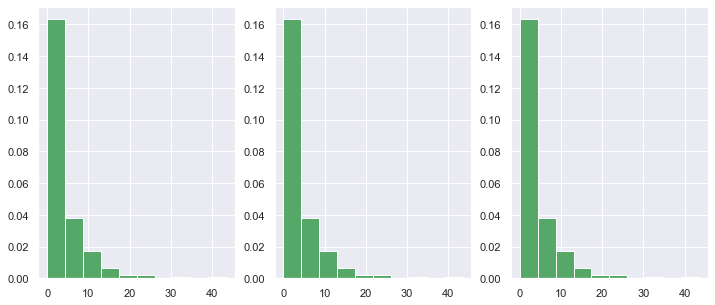

food
1/1 [==============================] - 0s 104ms/step


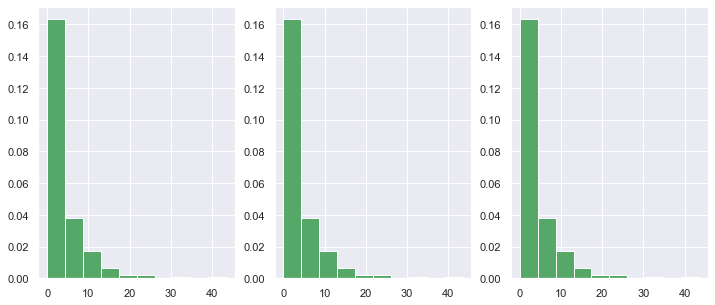

inside
1/1 [==============================] - 0s 106ms/step


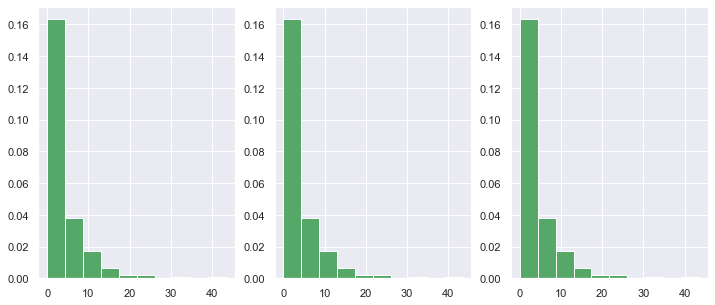

menu
1/1 [==============================] - 0s 106ms/step


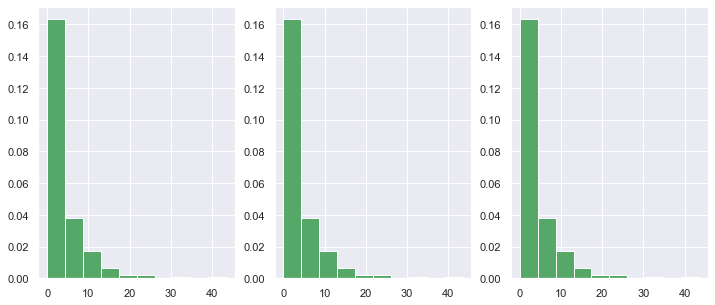

outside
1/1 [==============================] - 0s 118ms/step


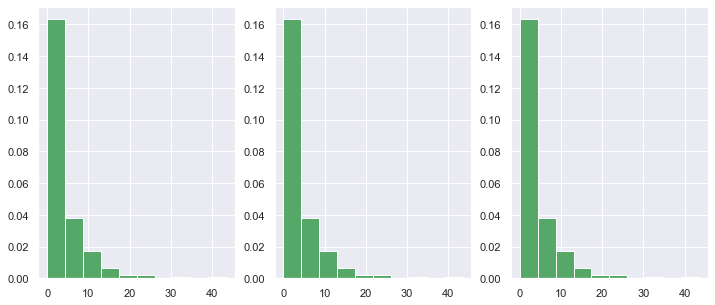

In [75]:
path = (path_photos+'/')

for name in list_labels :
    print(name)
    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(hspace=0.5)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        #filename = path + list_fct(weighted_images_df, name)[i+10]
        filename = list_fct(weighted_images_df, name)[i+10]
        filename_path = path + filename
        # load an image from file
        img = load_img(photo_example, target_size=(224, 224))  # Charger l'image
        
        # convert the image pixels to a numpy array
        img = img_to_array(img)  # Convertir en tableau numpy

        # reshape data for the model
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)

        # prepare the image for the VGG model
        img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

        # Extracting our features
        features = model.predict(img)

        #image_tag = weighted_images_df.loc[(weighted_images_df['image_full_name'] == filename), 'Class_Name_VGG']
        #plt.title(f'Images tagged {image_tag.values} has a features shape = {features.shape}')
        #plt.axis('off')
        #plt.grid(None)
        #plt.imshow(img)
        n, bins, patches = plt.hist(features.flatten(), density=True, color='g')
        
        #print(f'Images is tagged by VGG model as {image_tag.values}')
    plt.show()

In [76]:
# identification des classes d'images a partir de modèle CNN pré-entrainé
VGG_features = []

weighted_images_df['VGG_features'] = np.nan

range_study = n_sample #len(photos_name)

path = (path_photos+'/')

for name in list_labels : #We run on n_sample picture, of each of the 5 label sequentially.
    # print("-------")
    for image_num in range(range_study):
        #if image_num%100 == 0 : print(image_num)
        
        filename = list_fct(weighted_images_df, name)[image_num]
        filename_path = path + filename
        #preprocess Image: Open, Grayscale, (Resize), (Equalize), Blur in option
        #image = preprocess(filename_path, colors, resize, equalize, blur, ksize) #preprocess(filename, blur, ksize)
        
        #Classification CNN pré-entrainé
        # load an image from file
        img = load_img(filename_path, target_size=(224, 224))  # Charger l'image
        
        # convert the image pixels to a numpy array
        img = img_to_array(img)  # Convertir en tableau numpy
        
        # expand dimensions so that it represents a single 'sample'
        #img = expand_dims(img, axis=0)
        
        # reshape data for the model
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
        
        # prepare the image for the VGG model
        img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

        # Extracting our features
        features = model.predict(img)

        VGG_features.append(features[0])

VGG_features_by_img = np.asarray(VGG_features)

VGG_features_by_img_all  = np.concatenate(VGG_features_by_img, axis=0)

print()
print(f"Nombre de descripteurs à partir du VGG pré-entrainé : {VGG_features_by_img_all.shape}")


weighted_images_df['VGG_features'] = VGG_features
weighted_images_df

1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 122ms/step


1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 122ms/step


1/1 [==============================] - 0s 124ms/step


1/1 [==============================] - 0s 118ms/step


1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 122ms/step


1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 119ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 118ms/step


1/1 [==============================] - 0s 121ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 119ms/step


1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 122ms/step


1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 112ms/step

Nombre de descripteurs à partir du VGG pré-entrainé : (2560000,)


photo_id             business_id  \
0     sMc1HR7VqN701rPNJ45gFQ  9qXZSFq9vPdX4F6kGjXC-g   
1     AAIT9XhHeYaQzGxrulTgCA  vaCZdS9Q9wIHw-YwHoYErA   
2     DtChivzQ_Q-jerMe-IPRLg  U4hibwdvk2pACJeo6FaoIA   
3     lxhwyhUj7mIFggOCMTb9qg  NKplFLr1UebQxMLQAxALPQ   
4     WCOgPOvKZl46Y1itp7HbBw  T2NZEKXgfTIPothJrLyz2A   
...                      ...                     ...   
4995  KISm_mcT6qHDZd9nhGKzwQ  eWmcdBJPPQ_iSaNU8uIpFQ   
4996  hYv3AeA_gv0duRj0azLnDg  RnURR_OfKGejCsEshpS0ww   
4997  UyA9Y00P3VwCvn94CwIhHQ  _nSL2u-ZzX6kkAF2D2EZgQ   
4998  3ZagCnoYDHyhwZaPtu3FNw  fNEQqFCwj9cLw-kqLyHuHQ   
4999  841fkMKuWX750P0VYpXqFg  U3grYFIeu6RgAAQgdriHww   

                                                caption    label  \
0     Dragon Blood | Asian inspired Craft Cocktail w...    drink   
1                                     SandBar Nashville    drink   
2                                                   NaN    drink   
3                                           Mango Lassi    drink   
4                                                   NaN    drink   
...                                                 ...      ...   
4995                             From the killer patio.  outside   
4996                                                NaN  outside   
4997                                                NaN  outside   
4998                                                NaN  outside   
4999                                                NaN  outside   

                 image_full_name              image_name image_ext   size  \
0     sMc1HR7VqN701rPNJ45gFQ.jpg  sMc1HR7VqN701rPNJ45gFQ      .jpg  23285   
1     AAIT9XhHeYaQzGxrulTgCA.jpg  AAIT9XhHeYaQzGxrulTgCA      .jpg  19080   
2     DtChivzQ_Q-jerMe-IPRLg.jpg  DtChivzQ_Q-jerMe-IPRLg      .jpg  12698   
3     lxhwyhUj7mIFggOCMTb9qg.jpg  lxhwyhUj7mIFggOCMTb9qg      .jpg  28057   
4     WCOgPOvKZl46Y1itp7HbBw.jpg  WCOgPOvKZl46Y1itp7HbBw      .jpg  66185   
...                          ...                     ...       ...    ...   
4995  KISm_mcT6qHDZd9nhGKzwQ.jpg  KISm_mcT6qHDZd9nhGKzwQ      .jpg  13076   
4996  hYv3AeA_gv0duRj0azLnDg.jpg  hYv3AeA_gv0duRj0azLnDg      .jpg  38972   
4997  UyA9Y00P3VwCvn94CwIhHQ.jpg  UyA9Y00P3VwCvn94CwIhHQ      .jpg  47765   
4998  3ZagCnoYDHyhwZaPtu3FNw.jpg  3ZagCnoYDHyhwZaPtu3FNw      .jpg  35456   
4999  841fkMKuWX750P0VYpXqFg.jpg  841fkMKuWX750P0VYpXqFg      .jpg  34942   

                                                   path  label_encoded  \
0     C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              0   
1     C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              0   
2     C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              0   
3     C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              0   
4     C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              0   
...                                                 ...            ...   
4995  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              4   
4996  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              4   
4997  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              4   
4998  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              4   
4999  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              4   

     Class_Name_VGG  Class_Confidence_Level  \
0            goblet               36.495996   
1        beer_glass               12.219349   
2     measuring_cup               43.824661   
3     measuring_cup               56.379110   
4           toyshop               25.984296   
...             ...                     ...   
4995            cab               15.557389   
4996           dock               67.127258   
4997          patio               21.780433   
4998           yurt               23.947828   
4999     restaurant               22.206475   

                                           VGG_features  
0     [0.22089982, 3.3988097, 7.1959567, 2.3504944, ...  
1     [0.0, 0.35382947, 1.0123025, 

In [77]:
df_VGG_features = pd.DataFrame(VGG_features)
df_VGG_features.head()

0         1         2         3         4         5         6    \
0  0.220900  3.398810  7.195957  2.350494  0.181266  5.015590  0.344225   
1  0.000000  0.353829  1.012303  0.548123  1.433919  0.000000  2.311116   
2  0.000000  0.959738  1.894626  0.671971  0.765493  0.220354  2.603846   
3  0.354441  1.024595  2.123286  0.656815  1.794527  3.124457  7.805246   
4  0.000000  0.831561  0.356570  0.000000  2.388892  0.000000  0.000000   

        7        8         9    ...       502       503       504       505  \
0  3.611352  0.00000  5.595927  ...  2.750860  0.029993  3.510130  0.000000   
1  0.437367  0.00888  4.409832  ...  1.917732  2.062835  0.127455  1.926896   
2  0.000000  0.00000  0.060210  ...  3.102304  0.000000  0.000000  0.000000   
3  0.000000  0.00000  0.000000  ...  1.382771  0.721797  0.000000  0.000000   
4  5.066213  0.00000  2.029886  ...  0.079243  0.268549  0.000000  0.260945   

        506       507       508       509       510       511  
0  0.000000  0.000000  0.159792  2.742222  1.692798  1.746157  
1  0.000000  0.155554  6.280977  0.314205  1.066265  3.166116  
2  0.138413  1.897929  0.232445  0.233521  0.044021  0.000000  
3  0.000000  3.304065  1.942380  1.093800  0.733122  0.220900  
4  0.967671  1.685338  1.056145  0.046965  6.317961  0.482153  

[5 rows x 512 columns]

In [78]:
# Centrage et réduction
std_scale_VGG = StandardScaler().fit(df_VGG_features) #ou df_bow_sift_median
VGG_features_scaled = std_scale_VGG.transform(df_VGG_features)
df_VGG_features_scaled = pd.DataFrame(VGG_features_scaled)
df_VGG_features_scaled.head()

0         1         2         3         4         5         6    \
0 -0.482405  0.312570  0.434974  0.044692 -0.724895  1.261898 -0.501087   
1 -0.558144 -0.463294 -0.392489 -0.418840 -0.398217 -0.670291  0.150564   
2 -0.558144 -0.308908 -0.274421 -0.386989 -0.572535 -0.585402  0.247549   
3 -0.436618 -0.292383 -0.243823 -0.390887 -0.304175  0.533365  1.970825   
4 -0.558144 -0.341568 -0.480236 -0.559806 -0.149171 -0.670291 -0.615132   

        7         8         9    ...       502       503       504       505  \
0  0.626507 -0.288960  0.692740  ...  0.203613 -0.900306  1.223331 -0.556283   
1 -0.486292 -0.284443  0.385519  ... -0.067690 -0.206588 -0.359349 -0.107812   
2 -0.639633 -0.288960 -0.741116  ...  0.318059 -0.910541 -0.418982 -0.556283   
3 -0.639633 -0.288960 -0.756711  ... -0.241896 -0.664224 -0.418982 -0.556283   
4  1.136580 -0.288960 -0.230932  ... -0.666381 -0.818898 -0.418982 -0.495550   

        506       507       508       509       510       511  
0 -0.472260 -0.709706 -0.816138 -0.123037 -0.440425 -0.326717  
1 -0.472260 -0.657961  0.753356 -0.505764 -0.621116 -0.122670  
2 -0.417192 -0.078362 -0.797509 -0.518482 -0.915929 -0.577638  
3 -0.472260  0.389388 -0.359076 -0.382877 -0.717194 -0.545895  
4 -0.087272 -0.149080 -0.586310 -0.547889  0.893461 -0.508353  

[5 rows x 512 columns]

In [79]:
df_VGG_features_scaled.shape

(5000, 512)

In [108]:
#df_bow_VGG = pd.DataFrame(weighted_images_df['VGG_features'])

tsne_VGG = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=0)
X_tsne_VGG = tsne_VGG.fit_transform(df_VGG_features_scaled) #ou df_bow_VGG ou weighted_images_df['VGG_features'] ou VGG_features_scaled ou df_VGG_features_scaled

df_tsne_VGG = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_VGG["label"] = weighted_images_df['label']
df_tsne_VGG.head()

C:\Users\blanc\anaconda3\envs\IA_Projet6_Images_Webpage\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


tsne1      tsne2  label
0   8.829302  25.329067  drink
1  23.168583  20.631760  drink
2  36.853767  37.104542  drink
3  35.655396  35.725883  drink
4 -30.359541 -33.996014  drink

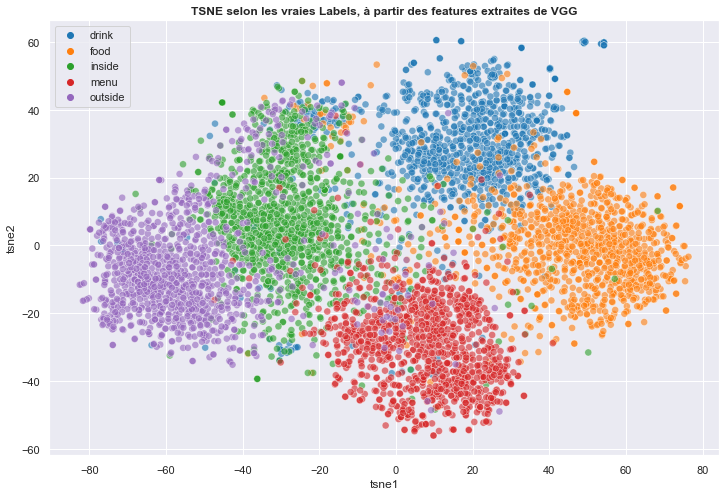

In [109]:
#Définir la taille du graphique
plt.figure(figsize=(12,8))
#Définir le type du graphique,
sns.scatterplot(
    x="tsne1", y="tsne2", hue="label", data=df_tsne_VGG, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)
#Afficher les titres et noms des axes
plt.title('TSNE selon les vraies Labels, à partir des features extraites de VGG', fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
#Afficher la légende 
plt.legend(loc='upper left')
#Afficher le graphique
plt.show()

In [110]:
n_clusters = 5

kmeans_VGG = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)
#print('start_fit:',k)
kmeans_VGG.fit(df_VGG_features_scaled)


C:\Users\blanc\anaconda3\envs\IA_Projet6_Images_Webpage\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


MiniBatchKMeans(n_clusters=5, random_state=0)

In [111]:
#save kmeans model in joblib files
dump(kmeans_VGG, './Models/kmeans_VGG.joblib')

dump(tsne_VGG, './Models/tsne_VGG.joblib')

#save stdscaler used to transform data
dump(std_scale_VGG, './Models/std_scale_VGG.joblib')


['./Models/std_scale_VGG.joblib']

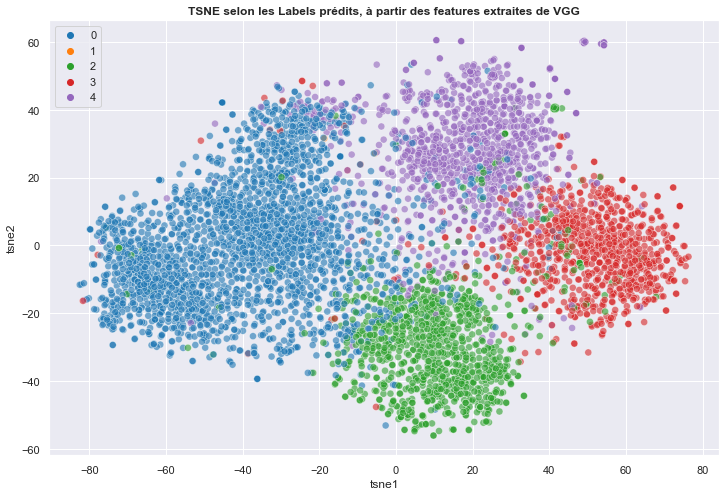

In [84]:
weighted_images_df['predict_clusters_VGG_features'] = kmeans_VGG.labels_ 
df_tsne_VGG["label_predicted"] = kmeans_VGG.labels_
#Définir la taille du graphique
plt.figure(figsize=(12,8))
#Définir le type du graphique,
sns.scatterplot(
    x="tsne1", y="tsne2", hue="label_predicted", data=df_tsne_VGG, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)
#Afficher les titres et noms des axes
plt.title('TSNE selon les Labels prédits, à partir des features extraites de VGG', fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
#Afficher la légende 
plt.legend(loc='upper left')
#Afficher le graphique
plt.show()

In [85]:
ARI = adjusted_rand_score(weighted_images_df["label_encoded"],weighted_images_df["predict_clusters_VGG_features"])
print(f'ARI value is {ARI}')

ARI value is 0.5034013798347551


### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (90%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [86]:
# Calcul des composantes principales - SIFT
print("Dimensions dataset avant réduction PCA : ", df_VGG_features_scaled.shape)
pca_VGG = decomposition.PCA()
feat_pca_VGG = pca_VGG.fit_transform(df_VGG_features_scaled)
print("Dimensions dataset après réduction PCA : ", feat_pca_VGG.shape)

Dimensions dataset avant réduction PCA :  (5000, 512)
Dimensions dataset après réduction PCA :  (5000, 512)


In [87]:
#nombre de composantes calculées
n_comp_VGG=pca_VGG.n_components_
n_comp_VGG

512

In [88]:
#variance expliquée / eigen values
eigval_VGG=pca_VGG.explained_variance_

#calcul de la somme des eigen values 
print(sum(eigval_VGG))

512.1023156791925


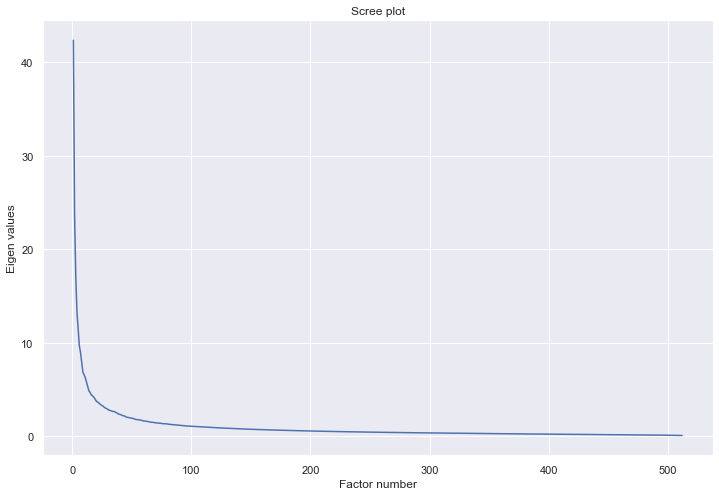

In [89]:
#Définir la taille du graphique
plt.figure(figsize=(12,8))
#scree plot
plt.plot(np.arange(1,n_comp_VGG+1),eigval_VGG)
plt.title("Scree plot")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
#plt.xlim(0, 10)
plt.show()

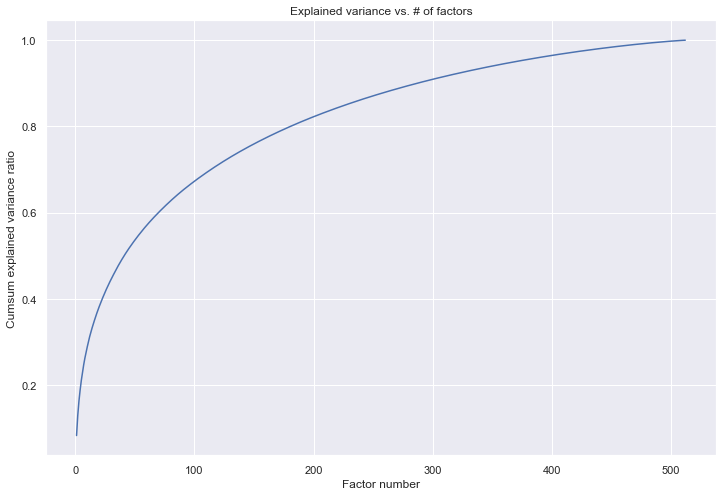

In [90]:
#proportion de variance expliquée
prop_eigval_VGG=pca_VGG.explained_variance_ratio_
#pd.DataFrame(prop_eigval_sift.cumsum())
#Définir la taille du graphique
plt.figure(figsize=(12,8))
#cumul de variance expliquée
plt.plot(np.arange(1,n_comp_VGG+1),np.cumsum(prop_eigval_VGG))
plt.title("Explained variance vs. # of factors")
plt.ylabel("Cumsum explained variance ratio")
plt.xlabel("Factor number")
#plt.xlim(0, 10)
plt.show()

In [91]:
explained_variance_VGG = pd.DataFrame(prop_eigval_VGG.cumsum()).iloc[300]
print(f'Explained variance after dimension reduction to 300 is = {round(explained_variance_VGG[0],4)}')

Explained variance after dimension reduction to 300 is = 0.9100000262260437


Avec 300 dimensions conservées sur 512, on conserve plus de 91% de l'information. <br>
On va maintenant réaliser la réduction de dimension :

In [92]:
# Calcul des composantes principales
pca_VGG = decomposition.PCA(300)
df_VGG_features_reduit = pd.DataFrame(pca_VGG.fit_transform(df_VGG_features))
df_VGG_features_reduit.head()

0          1          2          3          4          5    \
0  22.535761 -25.558613 -28.891748   3.413077 -20.549227   9.304303   
1  -7.402703 -20.457472 -22.803997  -0.899963 -12.382917  -2.214276   
2  20.782188  -1.780815 -55.433727   3.117875  -4.000890  17.782587   
3   1.546577  14.337667 -43.647182  19.593355   2.172229 -14.476246   
4 -41.572651   9.088753  56.422970  42.746025  12.741274  19.955887   

         6          7          8         9    ...       290       291  \
0 -28.011307  21.017721  20.852024  6.321561  ... -3.732891 -2.018794   
1   2.301781 -10.461153   1.235249  1.732508  ...  1.620046 -0.995847   
2  17.112976 -16.513779   5.096967 -7.232645  ... -0.719626  0.802636   
3  18.834518 -10.313123  -9.212790  1.304234  ... -1.210024 -0.039962   
4  46.201908 -17.112249  14.239860  5.200628  ...  1.691194  1.425996   

        292       293       294       295       296       297       298  \
0  0.615979  2.306795 -0.585216 -2.688877  2.314747  0.801894 -2.903432   
1 -3.296304 -2.114014  2.217810  3.312079 -0.655673  2.072546 -0.585772   
2 -0.998708 -0.956462  0.087250  0.024618 -0.506094 -0.793872 -1.063258   
3  0.771960 -0.584144 -0.825607  0.721811 -0.011454 -0.037168 -0.887264   
4  0.451904 -1.924090 -0.179166 -2.111040  1.567034  4.311967  0.576988   

        299  
0  1.185898  
1  2.135793  
2 -1.456634  
3  1.699337  
4  1.045441  

[5 rows x 300 columns]

In [93]:
# Centrage et réduction
std_scale_VGG_réduit = StandardScaler().fit(df_VGG_features_reduit) #ou df_bow_sift_median
df_VGG_features_scaled_reduit = std_scale_VGG_réduit.transform(df_VGG_features_reduit)
df_VGG_features_scaled_reduit = pd.DataFrame(df_VGG_features_scaled_reduit)
df_VGG_features_scaled_reduit.head()

0         1         2         3         4         5         6    \
0  0.651500 -0.753699 -1.243895  0.148464 -1.176085  0.576853 -1.866727   
1 -0.214009 -0.603272 -0.981795 -0.039147 -0.708706 -0.137282  0.153395   
2  0.600805 -0.052515 -2.386625  0.135623 -0.228981  1.102493  1.140442   
3  0.044711  0.422804 -1.879171  0.852283  0.124322 -0.897505  1.255169   
4 -1.201850  0.268019  2.429215  1.859391  0.729216  1.237235  3.078984   

        7         8         9    ...       290       291       292       293  \
0  1.510064  1.552964  0.498552  ... -1.857126 -1.012131  0.308849  1.164120   
1 -0.751605  0.091996  0.136635  ...  0.805979 -0.499272 -1.652745 -1.066834   
2 -1.186469  0.379599 -0.570405  ... -0.358016  0.402406 -0.500745 -0.482677   
3 -0.740969 -0.686127  0.102859  ... -0.601991 -0.020034  0.387056 -0.294788   
4 -1.229467  1.060520  0.410149  ...  0.841375  0.714931  0.226582 -0.970989   

        294       295       296       297       298       299  
0 -0.295885 -1.363719  1.180283  0.409838 -1.489407  0.609977  
1  1.121327  1.679789 -0.334324  1.059253 -0.300490  1.098562  
2  0.044114  0.012485 -0.258054 -0.405738 -0.545432 -0.749231  
3 -0.417427  0.366081 -0.005839 -0.018996 -0.455150  0.874068  
4 -0.090586 -1.070658  0.799027  2.203793  0.295984  0.537731  

[5 rows x 300 columns]

In [103]:
tsne_VGG_réduit = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=0)
X_tsne_VGG_reduit = tsne_VGG_réduit.fit_transform(df_VGG_features_scaled_reduit)

df_tsne_VGG_reduit = pd.DataFrame(X_tsne_VGG_reduit[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_VGG_reduit["label"] = weighted_images_df['label']
df_tsne_VGG_reduit.head()

C:\Users\blanc\anaconda3\envs\IA_Projet6_Images_Webpage\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


tsne1      tsne2  label
0  11.729048  13.840051  drink
1  13.263685   5.899783  drink
2  29.718361   1.331734  drink
3  30.081078  -0.393933  drink
4 -15.482592  -7.608987  drink

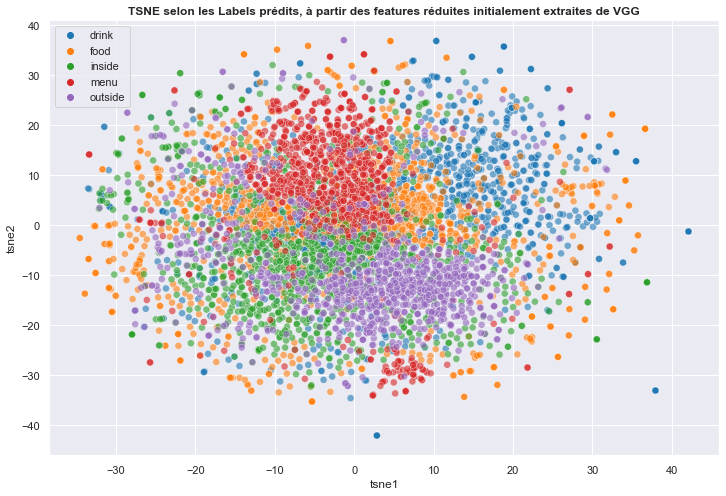

In [104]:
#Définir la taille du graphique
plt.figure(figsize=(12,8))
#Définir le type du graphique,
sns.scatterplot(
    x="tsne1", y="tsne2", hue="label", data=df_tsne_VGG_reduit, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)
#Afficher les titres et noms des axes
plt.title('TSNE selon les Labels prédits, à partir des features réduites initialement extraites de VGG', fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
#Afficher la légende 
plt.legend(loc='upper left')
#Afficher le graphique
plt.show()

In [105]:
#kmeans sur la matrice pre-ACP 
kmeans_VGG_réduit = MiniBatchKMeans(n_clusters=5, random_state=0) #MiniBatchKMeans(n_clusters=7, random_state=5)
kmeans_VGG_réduit.fit(df_VGG_features_scaled_reduit)
kmeans_VGG_réduit.labels_

C:\Users\blanc\anaconda3\envs\IA_Projet6_Images_Webpage\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


array([3, 4, 3, ..., 1, 1, 0])

In [106]:
#save kmeans model in joblib files
dump(kmeans_VGG_réduit, './Models/kmeans_VGG_réduit.joblib')

dump(tsne_VGG_réduit, './Models/tsne_VGG_réduit.joblib')

#save stdscaler used to transform data
dump(std_scale_VGG_réduit, './Models/std_scale_VGG_réduit.joblib')

['./Models/std_scale_VGG_réduit.joblib']

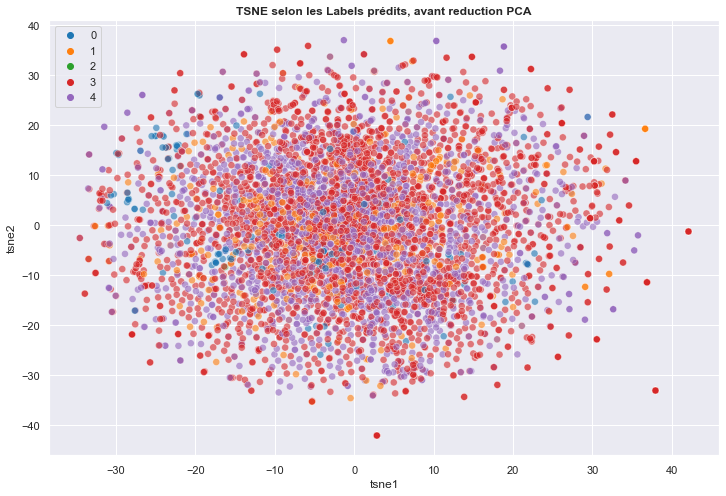

In [98]:
#Définir la taille du graphique
plt.figure(figsize=(12,8))
#Définir le type du graphique,
sns.scatterplot(
    x=df_tsne_VGG_reduit['tsne1'], y=df_tsne_VGG_reduit['tsne2'], hue=kmeans_VGG_réduit.labels_, data=kmeans_VGG_réduit, legend="brief", #X_tsne_reduit
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)
#Afficher les titres et noms des axes
plt.title('TSNE selon les Labels prédits, avant reduction PCA', fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
#Afficher la légende 
plt.legend(loc='upper left')
#Afficher le graphique
plt.show()

In [99]:
ARI = adjusted_rand_score(df_tsne_VGG_reduit["label"],kmeans_VGG_réduit.labels_)
print(f'ARI value is {ARI}')

ARI value is 0.006111974084514762


In [100]:
#Sauvegarde des données ayant été utilisées
df_VGG_features.to_csv("./Models/df_VGG_features.csv", index = False)
df_VGG_features_scaled.to_csv("./Models/df_VGG_features_scaled.csv", index = False)

df_VGG_features_reduit.to_csv("./Models/df_VGG_features_reduit.csv", index = False)
df_VGG_features_scaled_reduit.to_csv("./Models/df_VGG_features_scaled_reduit.csv", index = False)

#Sauvegarde des données ayant été utilisées
df_tsne_VGG_reduit.to_csv("./Models/df_tsne_VGG_reduit.csv", index = False)
df_tsne_VGG.to_csv("./Models/df_tsne_VGG.csv", index = False)

## Extraction de Feature CNN par VGG16 et Transfer Learning

Nous séparons notre jeu de données, et notre jeu de test.

Ensuite, nous appliquerons une fonction de traitement (preprocess_input) spécifique au réseau VGG16 dans notre cas. 

L'image sera labellisée avec la colonne 'label_predicted'.

### Séparation du jeu d'entrainement du modèle et du jeu de test

In [25]:
X_train, X_test, y_train, y_test = train_test_split(weighted_images_df, weighted_images_df['label'], test_size=0.2, random_state=0, stratify=weighted_images_df['label'])
print(X_train.shape)
print(X_test.shape)

(400, 12)
(100, 12)


In [26]:
path = (path_photos+'/')
classes = ["drink", "food", "interior", "menu", "outside"]

batch_size = 32

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.20)

train_generator = train_datagen.flow_from_dataframe(dataframe=X_train,
                                            directory=path,
                                            x_col="image_full_name",
                                            y_col="label",
                                            #subset="training",
                                            batch_size=batch_size,
                                            seed=42,
                                            shuffle=True,
                                            #class_mode="categorical",
                                            classes=classes,
                                            target_size=(224,224),
                                            #color_mode="grayscale",
                                            subset='training'
                                           )

#valid_datagen = ImageDataGenerator()

valid_generator = train_datagen.flow_from_dataframe(dataframe=X_train,
                                            directory=path,
                                            x_col="image_full_name",
                                            y_col="label",
                                            #subset="training",
                                            batch_size=batch_size,
                                            seed=42,
                                            shuffle=True,
                                            #class_mode="categorical",
                                            classes=classes,
                                            target_size=(224,224),
                                            #color_mode="grayscale",
                                            subset='validation'
                                            )

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(dataframe=X_test,
                                            directory=path,
                                            x_col="image_full_name",
                                            target_size=(224,224),
                                            batch_size=1,
                                            class_mode= None,
                                            #classes=classes,
                                            shuffle=False,
                                            )

Found 256 validated image filenames belonging to 5 classes.
Found 64 validated image filenames belonging to 5 classes.
Found 100 validated image filenames.


### Combinaison du VGG16 et de notre classifier

Nous utilisons le réseau VGG16 en ajoutant notre propre couche de classification:

 - Cette couche est un réseau de neurones classique qui va permettre à partir de la sortie du VGG16 de faire une prédiction.
 - Sa couche de sortie contient n neurones (n représentant le nombre de classes que nous souhaitons prédire) dans ce cas : 5.

Commençons par déclarer le réseau qui va nous servir de modèle de base :


In [27]:
# Déclaration des modèles VGG16 et EfficientNetB0 (sans le top qui est le classifier)

input_shape = (224,224,3)
base_model = VGG16(weights="imagenet",include_top=False,input_shape=input_shape,classes=5,pooling="avg")

effnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape,classes=5,pooling="avg")

In [28]:
for layer in base_model.layers:
    layer.trainable = False

In [29]:
#out = base_model.output

x = Flatten()(base_model.output) #last or out
#x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
     
base_model = Model(inputs=base_model.input, outputs=x)
base_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
     
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Transfer Learning

In [30]:
es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc= ModelCheckpoint('./Models/working/vgg16.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
callbacks=[es,mc]

In [31]:
epochs = 10 #30
 
history = base_model.fit(train_generator,
                         validation_data = train_generator,
                         steps_per_epoch = train_generator.n//train_generator.batch_size,
                         validation_steps = valid_generator.n//valid_generator.batch_size,
                         epochs=epochs,
                         callbacks=callbacks
                        )

Epoch 1/10
8/8 [==============================] - ETA: 0s - loss: 5.8406 - accuracy: 0.3281
Epoch 1: val_loss improved from inf to 2.59449, saving model to ./Models/working\vgg16.h5
8/8 [==============================] - 37s 5s/step - loss: 5.8406 - accuracy: 0.3281 - val_loss: 2.5945 - val_accuracy: 0.6094
Epoch 2/10
8/8 [==============================] - ETA: 0s - loss: 2.8606 - accuracy: 0.5352
Epoch 2: val_loss improved from 2.59449 to 1.62395, saving model to ./Models/working\vgg16.h5
8/8 [==============================] - 39s 5s/step - loss: 2.8606 - accuracy: 0.5352 - val_loss: 1.6240 - val_accuracy: 0.6562
Epoch 3/10
8/8 [==============================] - ETA: 0s - loss: 1.6317 - accuracy: 0.7031
Epoch 3: val_loss improved from 1.62395 to 1.18927, saving model to ./Models/working\vgg16.h5
8/8 [==============================] - 37s 5s/step - loss: 1.6317 - accuracy: 0.7031 - val_loss: 1.1893 - val_accuracy: 0.7656
Epoch 4/10
8/8 [==============================] - ETA: 0s - loss:

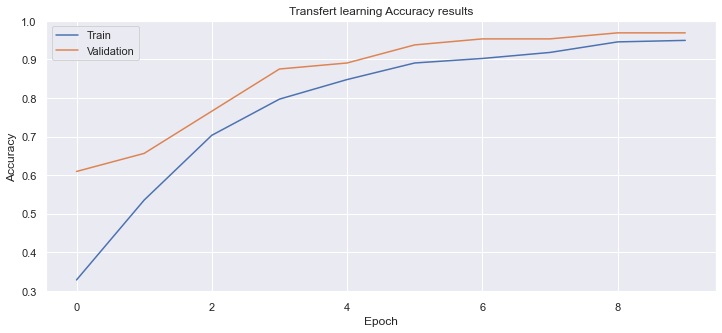

In [32]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.title('Transfert learning Accuracy results')
plt.show()

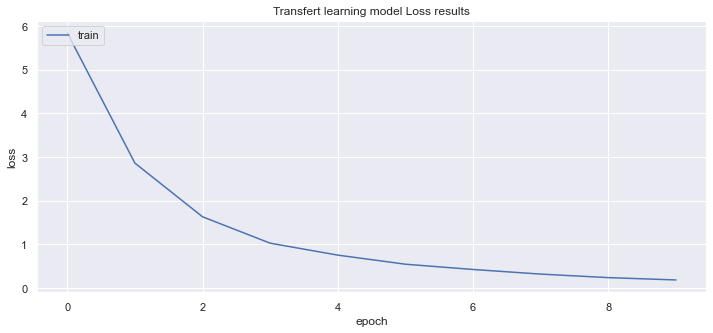

In [33]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.title('Transfert learning model Loss results')
plt.show()



In [34]:
score = base_model.evaluate(valid_generator)
print('val loss:', score[0])
print('val accuracy:', score[1])



2/2 [==============================] - 7s 4s/step - loss: 0.8794 - accuracy: 0.8594
val loss: 0.8794090151786804
val accuracy: 0.859375


In [35]:
# identification des classes d'images a partir de modèle CNN pré-entrainé
predicted_label = []
X_cnn = []

weighted_images_df['predicted_label'] = np.nan

range_study = n_sample #len(photos_name)

path = (path_photos+'/')
colors = 'BlackandWhite' #Other options = 'BlackandWhite', HSV
resize = False #False True
equalize = None #Other options: 'Hist', 'Clahe', None
blur = 'Gaussian' #Other options: None, 'Normal' ou 'Gaussian'
ksize = (5, 5) # ksize

for name in list_labels : #We run on n_sample picture, of each of the 5 label sequentially.
    # print("-------")
    for image_num in range(range_study):
        #if image_num%100 == 0 : print(image_num)
        
        filename = list_fct(weighted_images_df, name)[image_num]
        filename_path = path + filename
        #preprocess Image: Open, Grayscale, (Resize), (Equalize), Blur in option
        #image = preprocess(filename_path, colors, resize, equalize, blur, ksize) #preprocess(filename, blur, ksize)
        
        #Classification CNN pré-entrainé
        # load an image from file
        img = load_img(filename_path, target_size=(224, 224))  # Charger l'image
        
        # convert the image pixels to a numpy array
        img = img_to_array(img)  # Convertir en tableau numpy
        
        # reshape data for the model
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
        
        # prepare the image for the VGG model
        img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16
        #X_cnn.append(img)
        
        # predict the probability across all output classes
        y_predicted = base_model.predict(img) # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)
        
        # Get Max from y_predicted
        y_argmax = np.argmax(y_predicted)

        # retrieve the most likely result, e.g. highest probability
        y = list_labels[y_argmax]
        
        # print the classification
        #print(f'image {filename} label determined is : **{label[1]}** with confidence level = **{round(label[2]*100,2)} %**')
        
        predicted_label.append(y)
     
        
        weighted_images_df.loc[(weighted_images_df['image_full_name'] == filename), 'predicted_label'] = y
        
predicted_label_by_img = np.asarray(predicted_label)

print()
print("Les classes prédites (parmi le modèle Transfer Learning VGG) est: ", weighted_images_df.groupby(['predicted_label'])['predicted_label'].count())


1/1 [==============================] - 0s 154ms/step


1/1 [==============================] - 0s 138ms/step

Les classes prédites (parmi le modèle Transfer Learning VGG) est:  predicted_label
drink      127
food       110
menu       108
outside    155
Name: predicted_label, dtype: int64


In [36]:
weighted_images_df.groupby(['predicted_label'])['predicted_label'].count()

predicted_label
drink      127
food       110
menu       108
outside    155
Name: predicted_label, dtype: int64

In [37]:
weighted_images_df.groupby(['label'])['label'].count()

label
drink      100
food       100
inside     100
menu       100
outside    100
Name: label, dtype: int64

### Save Models for further reuse

In [39]:
#import joblib
#joblib.dump(base_model, './Models/vgg16_base_model.joblib')
base_model.save('./Models/vgg16_base_model.h5')
#joblib.dump(base_model, './Models/vgg16_base_model.joblib')
#history.save('./Models/history.h5')